In [62]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.signal import welch
import torch

Cargamos los datos

In [2]:
eeg1 = pd.read_csv("participantes/eeg_pp_3.csv")

features1 = pd.read_csv("participantes/eeg_features_3.csv")

In [3]:
eeg1.head()

,latency,fp1,fp2,f7,f3,fz,f4,f8,t7,c3,cz,c4,t8,p7,p3,pz,p4,p8,o1,o2
0,0.00325,-1.134083,-1.616393,-2.978469,9.451782,2.616204,-5.902781,3.800226,4.209862,-2.138382,0.071862,0.382011,5.023739,5.336211,1.677393,-1.798158,7.034395,-0.605010,-7.354033,-22.48079
1,0.00716,-4.706017,-3.627149,-2.270954,-7.003979,-6.565629,-12.403690,-1.197931,3.968418,-10.514600,-6.817259,-5.196234,7.299486,5.568435,1.398316,4.484427,10.952170,8.268439,7.287754,14.26811
2,0.01107,-6.159999,-4.736939,-1.542294,-14.263690,-10.801830,-16.914830,-5.584682,-0.292641,-12.102210,-10.391890,-8.981183,11.641750,4.545858,2.905325,9.491548,15.468500,10.149050,13.271700,35.51862
3,0.01497,-4.051315,-4.316872,0.507374,-13.321770,-9.760133,-15.520060,-5.704452,-4.428941,-1.439582,-6.204153,-6.188962,8.151788,6.938173,4.483890,8.024319,8.200095,3.866454,13.556850,27.25678
4,0.01888,-0.165028,-2.772018,3.198679,-7.452462,-5.166832,-9.639365,-2.003873,-4.061428,11.282410,2.142027,0.148558,-2.584346,10.243950,3.179628,1.222380,-6.748544,-2.416474,10.537820,2.78684


In [5]:
len(eeg1), len(features1)

(90880, 2260)

In [6]:
features1.isnull().sum()

epoch                    0
window                   0
n_samples                0
Start_w                  0
End_w                    0
                        ..
ch19-LowGamma-Kurt      20
ch19-LowGamma-RelPow     0
ch19-LowGamma-HjAct      0
ch19-LowGamma-HjMob      0
ch19-LowGamma-HjComp    10
Length: 1261, dtype: int64

In [4]:
features1['Trust'].value_counts(dropna=False)

Trust
4.0    1030
5.0     440
NaN     320
3.0     250
1.0     220
Name: count, dtype: int64

In [5]:
features1 = features1.dropna(subset=["Trust", "Binary_Trust"]).reset_index(drop=True)


Para llevar a cabo el análisis de la señal, hay que incorporar la columna "epoch" del dataset "features" al dataset con las señales EEG en crudo, para, más tarde, llevar a cabo la partición de los datos adecuada, se unirá esta columna según los valores de "Start_w" y "End_w" y considerando el valor de latencia de las señales. De esta manera, se obtendrá un dataset con las señales EEG en crudo, la epoch a la que pertenece, la latencia y el valor de Trust y Binary_Trust.

In [ ]:
def assign_epochs(eeg1, features1):
    eeg1 = eeg1.copy()
    eeg1["epoch"] = np.nan
    eeg1["Trust"] = np.nan
    eeg1["Binary_Trust"] = np.nan
    
    for _, row in features1.iterrows():
        mask = (eeg1["latency"] >= row["Start_w"]) & (eeg1["latency"] <= row["End_w"])
        eeg1.loc[mask, "epoch"] = row["epoch"]
        eeg1.loc[mask, "Trust"] = row["Trust"]
        eeg1.loc[mask, "Binary_Trust"] = row["Binary_Trust"]
    
    return eeg1

# Asignar etiquetas
eeg1 = assign_epochs(eeg1, features1)

# Ver cuántos valores se quedaron sin epoch
print("Sin epoch:", eeg1["epoch"].isna().sum(), "de un total de", len(eeg1))

# Ver distribución de etiquetas
print("\nDistribución Binary_Trust:")
print(eeg1["Binary_Trust"].value_counts(dropna=False))

print("\nDistribución Trust:")
print(eeg1["Trust"].value_counts(dropna=False))


C:\Users\crist\AppData\Local\Temp\ipykernel_38044\1576416167.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'low_trust' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  eeg1.loc[mask, "Binary_Trust"] = row["Binary_Trust"]


Sin epoch: 27585 de un total de 90880

Distribución Binary_Trust:
Binary_Trust
high_trust    46944
NaN           27585
low_trust     16351
Name: count, dtype: int64

Distribución Trust:
Trust
4.0    34078
NaN    27585
5.0    12866
1.0     8502
3.0     7849
Name: count, dtype: int64


Podemos observar que nos queda un alto % de valores nulos, esto se debe a que el primer start_w comienza más tarde que el primer valor de latencia, y lo mismo para el último valor de end_w, termina antes que el último valor de latencia. Estos nulos pueden corresponder con valores erróneos en la colocación inicial del casco o al momento de acabar el experimento, por lo que optamos por eliminarlos.

In [ ]:
# Eliminar filas donde alguna de las columnas clave es NaN
eeg1 = eeg1.dropna(subset=['epoch', 'Trust', 'Binary_Trust']).reset_index(drop=True)

# Ver cuántos valores se quedaron sin epoch
print("Sin epoch:", eeg1["epoch"].isna().sum(), "de un total de", len(eeg1))

# Ver distribución de etiquetas
print("\nDistribución Binary_Trust:")
print(eeg1["Binary_Trust"].value_counts(dropna=False))

print("\nDistribución Trust:")
print(eeg1["Trust"].value_counts(dropna=False))


Sin epoch: 0 de un total de 63295

Distribución Binary_Trust:
Binary_Trust
high_trust    46944
low_trust     16351
Name: count, dtype: int64

Distribución Trust:
Trust
4.0    34078
5.0    12866
1.0     8502
3.0     7849
Name: count, dtype: int64


C:\Users\crist\AppData\Local\Temp\ipykernel_38044\1673612113.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=eeg1['Binary_Trust'], palette='coolwarm', order=['high_trust', 'low_trust'])
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_

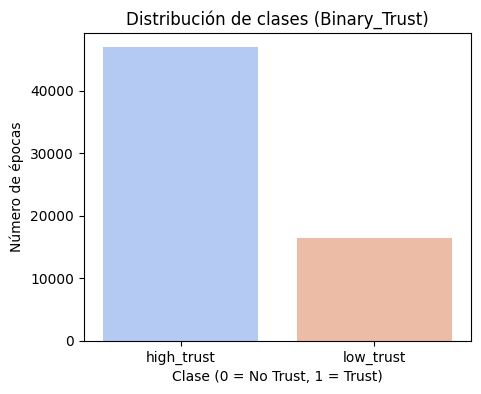

Distribución porcentual:
 Binary_Trust
high_trust    0.74167
low_trust     0.25833
Name: proportion, dtype: float64


In [64]:
plt.figure(figsize=(5,4))
sns.countplot(x=eeg1['Binary_Trust'], palette='coolwarm', order=['high_trust', 'low_trust'])
plt.title("Distribución de clases (Binary_Trust)")
plt.xlabel("Clase (0 = No Trust, 1 = Trust)")
plt.ylabel("Número de épocas")
plt.show()

print("Distribución porcentual:\n", eeg1['Binary_Trust'].value_counts(normalize=True))

In [ ]:
import os

def save_f1_history(clf, architecture, participant):
    f1_curve = clf.history_[:, 'f1_macro']
    df_new = pd.DataFrame({
        'epoch': range(1, len(f1_curve)+1),
        'f1': f1_curve,
        'architecture': architecture,
        'participant': participant
    })

    filename = "historial_f1_global.csv"

    if os.path.exists(filename):
        df_old = pd.read_csv(filename)
        df_final = pd.concat([df_old, df_new], ignore_index=True)
    else:
        df_final = df_new

    df_final.to_csv(filename, index=False)
    print(f"Guardado en {filename}")


## Red Neuronal EEGNet

In [9]:
from braindecode import EEGClassifier
from braindecode.models import EEGNet
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, f1_score
from skorch.helper import predefined_split

In [13]:
fs = 1 / (eeg1['latency'].iloc[1] - eeg1['latency'].iloc[0])
print("Frecuencia de muestreo (Hz):", fs)

Frecuencia de muestreo (Hz): 255.75024390241725


### Focal Loss

In [10]:
import torch.nn as nn
import torch.nn.functional as F
# Es una función de pérdida que nos sirve para clases desbalanceadas
# gamma controla cuánto penaliza la pérdida

class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        F_loss = (1 - pt) ** self.gamma * CE_loss
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss


### Trial Wise

In [ ]:
# Identificar todos los trials (epochs)
epochs = eeg1['epoch'].dropna().unique()

# Asociar cada trial a su etiqueta de confianza binaria
binary_trust_in_epoch = eeg1.groupby('epoch')['Binary_Trust'].first()

# Dividir trials en train, test y validación
epochs_train, epochs_test = train_test_split(
    epochs,
    test_size=0.2,
    stratify=binary_trust_in_epoch.loc[epochs].values,
    random_state=42
)

# Dentro de train, split train/valid
epochs_train, epochs_valid = train_test_split(
    epochs_train,
    test_size=0.2,  
    stratify=binary_trust_in_epoch[epochs_train],
    random_state=42
)

df_train = eeg1[eeg1['epoch'].isin(epochs_train)].reset_index(drop=True)
df_valid = eeg1[eeg1['epoch'].isin(epochs_valid)].reset_index(drop=True)
df_test  = eeg1[eeg1['epoch'].isin(epochs_test)].reset_index(drop=True)

def make_trial_windows(df, window_size, stride):
    trials = df['epoch'].unique()
    X_list, y_list = [], []

    for trial in trials:
        trial_df = df[df['epoch']==trial].drop(columns=['latency','Trust','Binary_Trust','epoch'], errors='ignore')
        trial_signals = trial_df.values  
        label = df[df['epoch']==trial]['Binary_Trust'].iloc[0]
        label_bin = 0 if label=='low_trust' else 1

        # Extraer ventanas con stride
        for start in range(0, trial_signals.shape[0] - window_size + 1, stride):
            window = trial_signals[start:start+window_size, :]
            X_list.append(window.T)  
            y_list.append(label_bin)

    X_tensor = torch.tensor(X_list, dtype=torch.float32)
    y_tensor = torch.tensor(y_list, dtype=torch.long)

    return X_tensor, y_tensor

X_train_t, y_train_t = make_trial_windows(df_train, window_size=256, stride=32)
X_valid_t, y_valid_t = make_trial_windows(df_valid, window_size=256, stride=32)
X_test_t,  y_test_t  = make_trial_windows(df_test,  window_size=256, stride=32)


C:\Users\crist\AppData\Local\Temp\ipykernel_38044\722965881.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  X_tensor = torch.tensor(X_list, dtype=torch.float32)


### Selección de características

#### Métodos Filter

In [ ]:
# === 2. Selección de canales (ANOVA) ===
from sklearn.feature_selection import f_classif
import numpy as np

# Convertimos a numpy y aplanamos por tiempo para tener una feature por canal
X_train_mean = X_train_t.mean(dim=2).numpy()
y_np = y_train_t.numpy()

# Calculamos F y p-values
F_values, pvals = f_classif(X_train_mean, y_np)

# Escogemos los canales con p<0.05 (significativos)
k = 10  
selected_channels = np.argsort(F_values)[-k:]  
print("Canales seleccionados:", selected_channels)


# Filtramos los tensores
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]

print("Nueva forma de X_train:", X_train_t.shape)


Canales seleccionados: [10  4  6 17 18 12 13  9  2  1]
Nueva forma de X_train: torch.Size([532, 10, 256])


In [ ]:
from sklearn.feature_selection import mutual_info_classif

X_train_mean = X_train_t.mean(dim=2).numpy()
y_np = y_train_t.numpy()

# Mutual information
mi = mutual_info_classif(X_train_mean, y_np, random_state=42)
selected_channels = np.argsort(mi)[-10:]  

print("Canales seleccionados (MI):", selected_channels)

# Filtra los tensores
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]
print("Nueva forma de X_train:", X_train_t.shape)

Canales seleccionados (MI): [ 3  0 15 13  8  4 11 10  1  6]
Nueva forma de X_train: torch.Size([532, 10, 256])


#### Método híbrido (filter+wrapper)

In [202]:
from sklearn.feature_selection import mutual_info_classif, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

X_mean = X_train_t.numpy().mean(axis=2)
mi = mutual_info_classif(X_mean, y_train_t.numpy(), random_state=42)
top_k = min(14, X_mean.shape[1])
top_channels = np.argsort(mi)[-top_k:]
X_filtered = X_mean[:, top_channels]

wrapper = SequentialFeatureSelector(
        LogisticRegression(max_iter=1000),
        n_features_to_select=min(10, top_k),
        direction='forward',
        n_jobs=-1
    )
wrapper.fit(X_filtered, y_train_t.numpy())
selected_channels = top_channels[wrapper.get_support()]
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]
print("Canales finales (híbrido):", selected_channels)


Canales finales (híbrido): [12  5  7  3  0 13  8  4 10  6]


### Normalización

In [ ]:
mean = X_train_t.mean(dim=(0,2), keepdim=True)  
std  = X_train_t.std(dim=(0,2), keepdim=True)
X_train_t = (X_train_t - mean) / (std + 1e-8)
X_valid_t = (X_valid_t - mean) / (std + 1e-8)
X_test_t  = (X_test_t - mean) / (std + 1e-8)


### Oversampling aleatorio

In [ ]:
import torch

# Convertir etiquetas a numpy si son tensores
y_np = y_train_t.cpu().numpy() if torch.is_tensor(y_train_t) else y_train_t

# Contar ejemplos por clase
counts = np.bincount(y_np)
majority_class = np.argmax(counts)
minority_class = 1 - majority_class

# Índices de cada clase
idx_majority = np.where(y_np == majority_class)[0]
idx_minority = np.where(y_np == minority_class)[0]

# Oversampling: replicar aleatoriamente la minoritaria hasta igualar
idx_minority_upsampled = np.random.choice(idx_minority, size=len(idx_majority), replace=True)

# Combinar y mezclar
indices_balanced = np.concatenate([idx_majority, idx_minority_upsampled])
np.random.shuffle(indices_balanced)

# Crear los nuevos conjuntos
X_train_bal = X_train_t[indices_balanced]
y_train_bal = y_train_t[indices_balanced]

print("Nuevo tamaño:", len(y_train_bal))
print("Distribución balanceada:", torch.bincount(y_train_bal))


Nuevo tamaño: 776
Distribución balanceada: tensor([388, 388])


### SMOTE

In [120]:
from imblearn.over_sampling import SMOTE
# --- Aplanar para aplicar SMOTE ---
X_train_flat = X_train_t.reshape(X_train_t.shape[0], -1).numpy()
y_train_np = y_train_t.numpy()

print("Antes del SMOTE:", np.bincount(y_train_np))

# --- Aplicar SMOTE ---
sm = SMOTE(random_state=42, k_neighbors=5)
X_train_res, y_train_res = sm.fit_resample(X_train_flat, y_train_np)

print("Después del SMOTE:", np.bincount(y_train_res))

# --- Volver a formato tensor (3D) ---
# Recuperamos el número de canales y tamaño de ventana original
n_channels = X_train_t.shape[1]
window_size = X_train_t.shape[2]

X_train_bal = torch.tensor(X_train_res, dtype=torch.float32).reshape(-1, n_channels, window_size)
y_train_bal = torch.tensor(y_train_res, dtype=torch.long)

Antes del SMOTE: [144 388]
Después del SMOTE: [388 388]


In [18]:
overlap = set(epochs_train).intersection(set(epochs_test))
print("Épocas repetidas en train y test:", overlap)

Épocas repetidas en train y test: set()


In [19]:
print("Train windows:", X_train_t.shape[0])
print("Valid windows:", X_valid_t.shape[0])
print("Test windows:",  X_test_t.shape[0])


Train windows: 532
Valid windows: 131
Test windows: 190


### Modelo y entrenamiento

#### Creación del modelo

In [ ]:
chans = 19      
nb_classes = 2   

model = EEGNet(
    n_chans= chans,
    n_outputs= nb_classes,
    input_window_seconds= 1,
    n_times = 256,
    drop_prob=0.5,
    F1=8,F2=16,
)

In [28]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss( weight=class_weights)
# criterion = FocalLoss(alpha=0.7, gamma=1.5, reduction='mean')

#### Entrenamiento del modelo

In [29]:
from skorch.callbacks import EarlyStopping, EpochScoring

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False)

early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=20,
    threshold=0.001,
    lower_is_better=True,
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-2,
    optimizer__lr=1e-4,
    batch_size=64,
    callbacks=[f1_macro],
    max_epochs=40,
    device='cpu',
)


In [30]:
# clf.fit(X_train_t, y_train_t)
clf.fit(X_train_bal, y_train_bal)

  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.4912        0.6810       0.4962        0.6914  1.6864
      2      0.4881        0.6792       0.4885        0.6913  0.9952
      3      0.4732        0.6672       0.4733        0.6911  0.6312
      4      0.4654        0.6618       0.4656        0.6908  0.6247
      5      0.4732        0.6549       0.4733        0.6905  0.6003
      6      0.4656        0.6444       0.4656        0.6904  0.5702
      7      0.4575        0.6518       0.4580        0.6902  0.6349
      8      0.4496        0.6317       0.4504        0.6900  0.6448
      9      0.4569        0.6315       0.4580        0.6900  0.8407
     10      0.4641        0.6183       0.4656        0.6899  0.6341
     11      0.4560        0.6210       0.4580        0.6896  0.8098
     12      0.4560        0.6100       0.4580        0.6891  0.7921
     13      0.4141        0.6059 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNet (EEGNet)                                              [1, 19, 256]              [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                                 [1, 19, 256]              [1, 19, 256, 1]           --                        --
  ├─Rearrange (dimshuffle): 1-2                                [1, 19, 256, 1]           [1, 1, 19, 256]           --                        --
  ├─Conv2d (conv_temporal): 1-3                                [1, 1, 19, 256]           [1, 8, 19, 257]           512                       [1, 64]
  ├─BatchNorm2d (bnorm_temporal): 1-4                          [1, 8, 19, 257]           [1, 8, 19, 257]           16                        --
  ├─ParametrizedConv2dWithConstraint (conv_spatial): 1-5       [1, 8, 19, 257]           [1, 16, 1, 257]           --                        [19, 1]
  │    └─ModuleDict (parametrizations): 2-1                    --                        --                        --                        --
  │    │    └─ParametrizationList (weight): 3-1                --                        [16, 1, 19, 1]            304                       --
  ├─BatchNorm2d (bnorm_1): 1-6                                 [1, 16, 1, 257]           [1, 16, 1, 257]           32                        --
  ├─ELU (elu_1): 1-7                                           [1, 16, 1, 257]           [1, 16, 1, 257]           --                        --
  ├─AvgPool2d (pool_1): 1-8                                    [1, 16, 1, 257]           [1, 16, 1, 64]            --                        [1, 4]
  ├─Dropout (drop_1): 1-9                                      [1, 16, 1, 64]            [1, 16, 1, 64]            --                        --
  ├─Conv2d (conv_separable_depth): 1-10                        [1, 16, 1, 64]            [1, 16, 1, 65]            256                       [1, 16]
  ├─Conv2d (conv_separable_point): 1-11                        [1, 16, 1, 65]            [1, 16, 1, 65]            256                       [1, 1]
  ├─BatchNorm2d (bnorm_2): 1-12                                [1, 16, 1, 65]            [1, 16, 1, 65]            32                        --
  ├─ELU (elu_2): 1-13                                          [1, 16, 1, 65]            [1, 16, 1, 65]            --                        --
  ├─AvgPool2d (pool_2): 1-14                                   [1, 16, 1, 65]            [1, 16, 1, 8]             --                        [1, 8]
  ├─Dropout (drop_2): 1-15                                     [1, 16, 1, 8]             [1, 16, 1, 8]             --                        --
  ├─Sequential (final_layer): 1-16                             [1, 16, 1, 8]             [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-2                         [1, 16, 1, 8]             [1, 2, 1, 1]              258                       [1, 8]
  │    └─Rearrange (permute_back): 2-3                         [1, 2, 1, 1]              [1, 2, 1, 1]              --                        --
  │    └─SqueezeFinalOutput (squeeze): 2-4                     [1, 2, 1, 1]              [1, 2]                    --                        --
  │    │    └─Rearrange (squeeze): 3-2                         [1, 2, 1, 1]              [1, 2, 1]                 --                        --
  ==========================================================================================================

#### Test

In [ ]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas 
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))
f1 = f1_score(y_test_t, y_pred, average='macro')
print(f"\nF1-Score (macro): {f1:.4f}")

[[ 49   2]
 [135   4]]
              precision    recall  f1-score   support

           0       0.27      0.96      0.42        51
           1       0.67      0.03      0.06       139

    accuracy                           0.28       190
   macro avg       0.47      0.49      0.24       190
weighted avg       0.56      0.28      0.15       190


F1-Score (macro): 0.2361


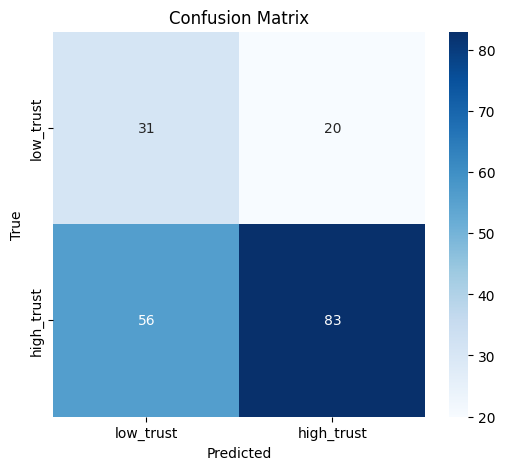

In [ ]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred)

# Opcional: nombres de las clases
class_names = ['low_trust', 'high_trust']

# 3️⃣ Crear el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1]  
y_true = y_test_t.numpy()

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.487


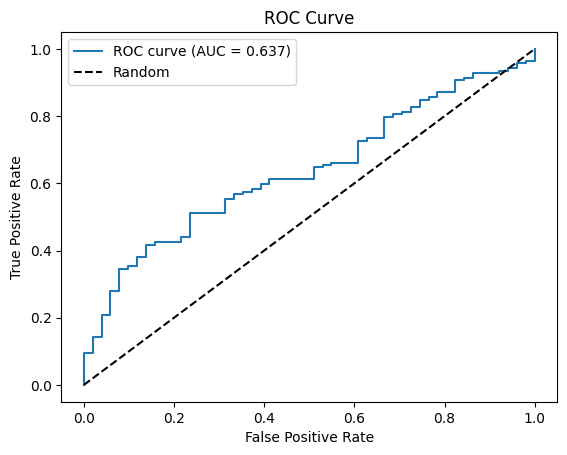

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [138]:
save_f1_history(
    clf=clf,
    architecture="EEGNet",
    participant="P3"
)

Guardado en historial_f1_global.csv


## EEGNeX

In [33]:
from braindecode.models import EEGNeX

In [ ]:
chans = 19    
nb_classes = 2   

model = EEGNeX(
    n_chans= chans,
    n_outputs= nb_classes,
    input_window_seconds= 1,
    n_times = 256,
    drop_prob=0.5,
)

In [42]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
# criterion = FocalLoss(alpha=0.7, gamma=1.5, reduction='mean')

In [ ]:
from skorch.callbacks import EarlyStopping, EpochScoring

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False, on_train=False)

early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=20,
    threshold=0.001,
    lower_is_better=True,
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-3,
    optimizer__lr=1e-3,
    batch_size=64,
    callbacks=[early_stopping, f1_macro],
    max_epochs=30,
    device='cpu',
)


In [44]:
# clf.fit(X_train_t, y_train_t)
clf.fit(X_train_bal, y_train_bal)

  epoch    f1_macro    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.3841        0.6173       0.4122        0.6874  24.7879
      2      0.4653        0.5427       0.4733        0.6727  25.0540
      3      0.4138        0.4731       0.4351        0.6889  25.4058
      4      0.5793        0.4108       0.5802        0.6340  13.0710
      5      0.5374        0.3810       0.5420        0.6280  10.5869
      6      0.6487        0.3523       0.6489        0.5944  24.6571
      7      0.6844        0.3030       0.6870        0.5365  14.5448
      8      0.7130        0.2644       0.7252        0.5091  12.0305
      9      0.7750        0.2304       0.7939        0.4894  24.1651
     10      0.7094        0.2160       0.7176        0.5093  23.5169
     11      0.7148        0.1894       0.7252        0.4785  10.8237
     12      0.7130        0.1744       0.7252        0.4489  11.5114
     13      0.6823 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNeX (EEGNeX)                                              [1, 19, 256]              [1, 2]                    --                        --
  ├─Sequential (block_1): 1-1                                  [1, 19, 256]              [1, 8, 19, 256]           --                        --
  │    └─Rearrange (0): 2-1                                    [1, 19, 256]              [1, 1, 19, 256]           --                        --
  │    └─Conv2d (1): 2-2                                       [1, 1, 19, 256]           [1, 8, 19, 256]           512                       [1, 64]
  │    └─BatchNorm2d (2): 2-3                                  [1, 8, 19, 256]           [1, 8, 19, 256]           16                        --
  ├─Sequential (block_2): 1-2                                  [1, 8, 19, 256]           [1, 32, 19, 256]          --                        --
  │    └─Conv2d (0): 2-4                                       [1, 8, 19, 256]           [1, 32, 19, 256]          16,384                    [1, 64]
  │    └─BatchNorm2d (1): 2-5                                  [1, 32, 19, 256]          [1, 32, 19, 256]          64                        --
  ├─Sequential (block_3): 1-3                                  [1, 32, 19, 256]          [1, 64, 1, 64]            --                        --
  │    └─ParametrizedConv2dWithConstraint (0): 2-6             [1, 32, 19, 256]          [1, 64, 1, 256]           --                        [19, 1]
  │    │    └─ModuleDict (parametrizations): 3-1               --                        --                        1,216                     --
  │    └─BatchNorm2d (1): 2-7                                  [1, 64, 1, 256]           [1, 64, 1, 256]           128                       --
  │    └─ELU (2): 2-8                                          [1, 64, 1, 256]           [1, 64, 1, 256]           --                        --
  │    └─AvgPool2d (3): 2-9                                    [1, 64, 1, 256]           [1, 64, 1, 64]            --                        [1, 4]
  │    └─Dropout (4): 2-10                                     [1, 64, 1, 64]            [1, 64, 1, 64]            --                        --
  ├─Sequential (block_4): 1-4                                  [1, 64, 1, 64]            [1, 32, 1, 64]            --                        --
  │    └─Conv2d (0): 2-11                                      [1, 64, 1, 64]            [1, 32, 1, 64]            32,768                    [1, 16]
  │    └─BatchNorm2d (1): 2-12                                 [1, 32, 1, 64]            [1, 32, 1, 64]            64                        --
  ├─Sequential (block_5): 1-5                                  [1, 32, 1, 64]            [1, 64]                   --                        --
  │    └─Conv2d (0): 2-13                                      [1, 32, 1, 64]            [1, 8, 1, 64]             4,096                     [1, 16]
  │    └─BatchNorm2d (1): 2-14                                 [1, 8, 1, 64]             [1, 8, 1, 64]             16                        --
  │    └─ELU (2): 2-15                                         [1, 8, 1, 64]             [1, 8, 1, 64]             --                        --
  │    └─AvgPool2d (3): 2-16                                   [1, 8, 1, 64]             [1, 8, 1, 8]              --                        [1, 8]
  │    └─Dropout (4): 2-17                                     [1, 8, 1, 8]              [1, 8, 1, 8]     

In [ ]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))
f1 = f1_score(y_test_t, y_pred, average='macro')
print(f"\nF1-Score (macro): {f1:.4f}")

[[14 37]
 [43 96]]
              precision    recall  f1-score   support

           0       0.25      0.27      0.26        51
           1       0.72      0.69      0.71       139

    accuracy                           0.58       190
   macro avg       0.48      0.48      0.48       190
weighted avg       0.59      0.58      0.59       190


F1-Score (macro): 0.4826


In [ ]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1] 
y_true = y_test_t.numpy()

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.554


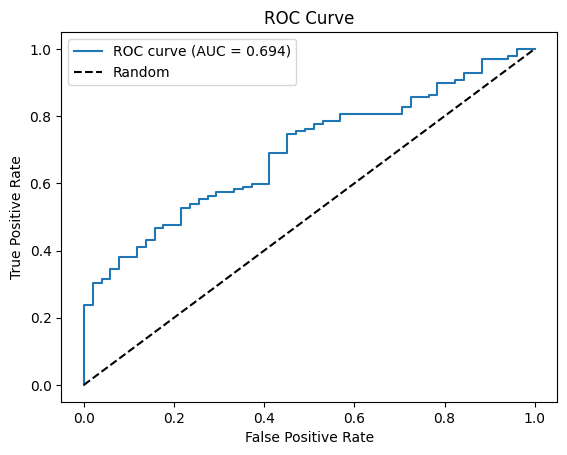

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [130]:
save_f1_history(
    clf=clf,
    architecture="EEGNeX",
    participant="P3"
)

Guardado en historial_f1_global.csv


## AttentionBaseNet

In [47]:
from braindecode.models import AttentionBaseNet


In [55]:
model = AttentionBaseNet(
    n_chans=19,
    n_outputs=2,
    n_times=256,
    drop_prob_inp=0.2,
    drop_prob_attn= 0.6,

)


In [56]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
# criterion = FocalLoss(alpha= 0.8, gamma=2)

In [57]:
from skorch.callbacks import EarlyStopping, EpochScoring

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False, on_train=False)

early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=15,
    threshold=0.001,
    lower_is_better=True,
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-2,
    optimizer__lr=1e-3,
    batch_size=64,
    callbacks=[ 
               f1_macro,],
    max_epochs=30,
    device='cpu',
)


In [58]:
clf.fit(
    X_train_bal, 
    y_train_bal, 
)

# clf.fit(X_train_t, y_train_t)

  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.2471        0.6762       0.3282        0.7144  1.5899
      2      0.2471        0.6242       0.3282        0.6984  1.3168
      3      0.4161        0.6002       0.4427        0.6606  1.1433
      4      0.4423        0.5773       0.4580        0.6518  1.0028
      5      0.4826        0.5532       0.4885        0.6747  2.2555
      6      0.4702        0.5225       0.4733        0.6494  2.9695
      7      0.4842        0.5068       0.4885        0.6535  2.9085
      8      0.4785        0.4935       0.4809        0.6395  2.7094
      9      0.4758        0.4540       0.4809        0.6377  2.6320
     10      0.5359        0.4391       0.5420        0.6158  2.6933
     11      0.5334        0.4014       0.5344        0.6408  3.0607
     12      0.6019        0.3817       0.6031        0.6083  2.6655
     13      0.5801        0.3638 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  AttentionBaseNet (AttentionBaseNet)                          [1, 19, 256]              [1, 2]                    --                        --
  ├─_FeatureExtractor (input_block): 1-1                       [1, 19, 256]              [1, 40, 1, 13]            --                        --
  │    └─Ensure4d (ensure4d): 2-1                              [1, 19, 256]              [1, 19, 256, 1]           --                        --
  │    └─Rearrange (rearrange_input): 2-2                      [1, 19, 256, 1]           [1, 1, 19, 256]           --                        --
  │    └─Conv2d (temporal_conv): 2-3                           [1, 1, 19, 256]           [1, 40, 19, 256]          1,000                     [1, 25]
  │    └─BatchNorm2d (intermediate_bn): 2-4                    [1, 40, 19, 256]          [1, 40, 19, 256]          80                        --
  │    └─Conv2d (spatial_conv): 2-5                            [1, 40, 19, 256]          [1, 40, 1, 256]           760                       [19, 1]
  │    └─BatchNorm2d (bn): 2-6                                 [1, 40, 1, 256]           [1, 40, 1, 256]           80                        --
  │    └─ELU (nonlinearity): 2-7                               [1, 40, 1, 256]           [1, 40, 1, 256]           --                        --
  │    └─AvgPool2d (pool): 2-8                                 [1, 40, 1, 256]           [1, 40, 1, 13]            --                        [1, 75]
  │    └─Dropout (dropout): 2-9                                [1, 40, 1, 13]            [1, 40, 1, 13]            --                        --
  ├─Sequential (channel_expansion): 1-2                        [1, 40, 1, 13]            [1, 16, 1, 13]            --                        --
  │    └─Conv2d (0): 2-10                                      [1, 40, 1, 13]            [1, 16, 1, 13]            640                       [1, 1]
  │    └─BatchNorm2d (1): 2-11                                 [1, 16, 1, 13]            [1, 16, 1, 13]            32                        --
  │    └─ELU (2): 2-12                                         [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  ├─_ChannelAttentionBlock (channel_attention_block): 1-3      [1, 16, 1, 13]            [1, 16, 1, 1]             --                        --
  │    └─Sequential (conv): 2-13                               [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  │    │    └─Conv2d (0): 3-1                                  [1, 16, 1, 13]            [1, 16, 1, 13]            240                       [1, 15]
  │    │    └─Conv2d (1): 3-2                                  [1, 16, 1, 13]            [1, 16, 1, 13]            256                       [1, 1]
  │    │    └─BatchNorm2d (2): 3-3                             [1, 16, 1, 13]            [1, 16, 1, 13]            32                        --
  │    │    └─ELU (3): 3-4                                     [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  │    └─AvgPool2d (pool): 2-14                                [1, 16, 1, 13]            [1, 16, 1, 1]             --                        [1, 8]
  │    └─Dropout (dropout): 2-15                               [1, 16, 1, 1]             [1, 16, 1, 1]             --                        --
  ├─Sequential (final_layer): 1-4                              [1, 16, 1, 1]             [1, 2]            

In [ ]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas 
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[ 13  38]
 [ 34 105]]
              precision    recall  f1-score   support

           0       0.28      0.25      0.27        51
           1       0.73      0.76      0.74       139

    accuracy                           0.62       190
   macro avg       0.51      0.51      0.50       190
weighted avg       0.61      0.62      0.62       190



In [ ]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1]  
y_true = y_test_t.numpy()

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.629


In [145]:
save_f1_history(
    clf=clf,
    architecture="AttentionBaseNet",
    participant="P3"
)

Guardado en historial_f1_global.csv
